# Halfar Shallow Ice Model Decapode to Neuromancer Solution

### Load dependencies

In [12]:
import Pkg
Pkg.add(["CombinatorialSpaces", "GeometryBasics", "MultiScaleArrays", "MLStyle", 
        "OrdinaryDiffEq", "LinearAlgebra", "GLMakie", "Logging", "JLD2", "Printf"])

# AlgebraicJulia Dependencies
using Catlab
using Catlab.Graphics
using CombinatorialSpaces
using Decapodes

# External Dependencies
using MLStyle
using MultiScaleArrays
using LinearAlgebra
using OrdinaryDiffEq
using JLD2
using SparseArrays
# Uncomment to load GLMakie if your system supports it.
# Otherwise, do using CairoMakie
using GLMakie
using GeometryBasics: Point2
Point2D = Point2{Float64}

   Resolving package versions...
  No Changes to `~/Projects/Decapodes.jl/Project.toml`
  No Changes to `~/Projects/Decapodes.jl/Manifest.toml`


Point2{Float64} (alias for Point{2, Float64})

## Define the Halfar Model as a Decapode

The [Halfar model](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/JC086iC11p11065) describes the time evolution of the height of an ice sheet $H(t, x)$, as a function of time $t$ and horizontal distance $x$ from the center of an ice cap. For more information, see section 8.1.1 [here](https://cism.github.io/data/cism_documentation_v2_1.pdf).
Model Equations: \begin{equation}
    \frac{\partial H}{\partial t} = \nabla \cdot \left( \Gamma H^{n+2} |\nabla H|^{n-1} \nabla H \right) 
\end{equation}

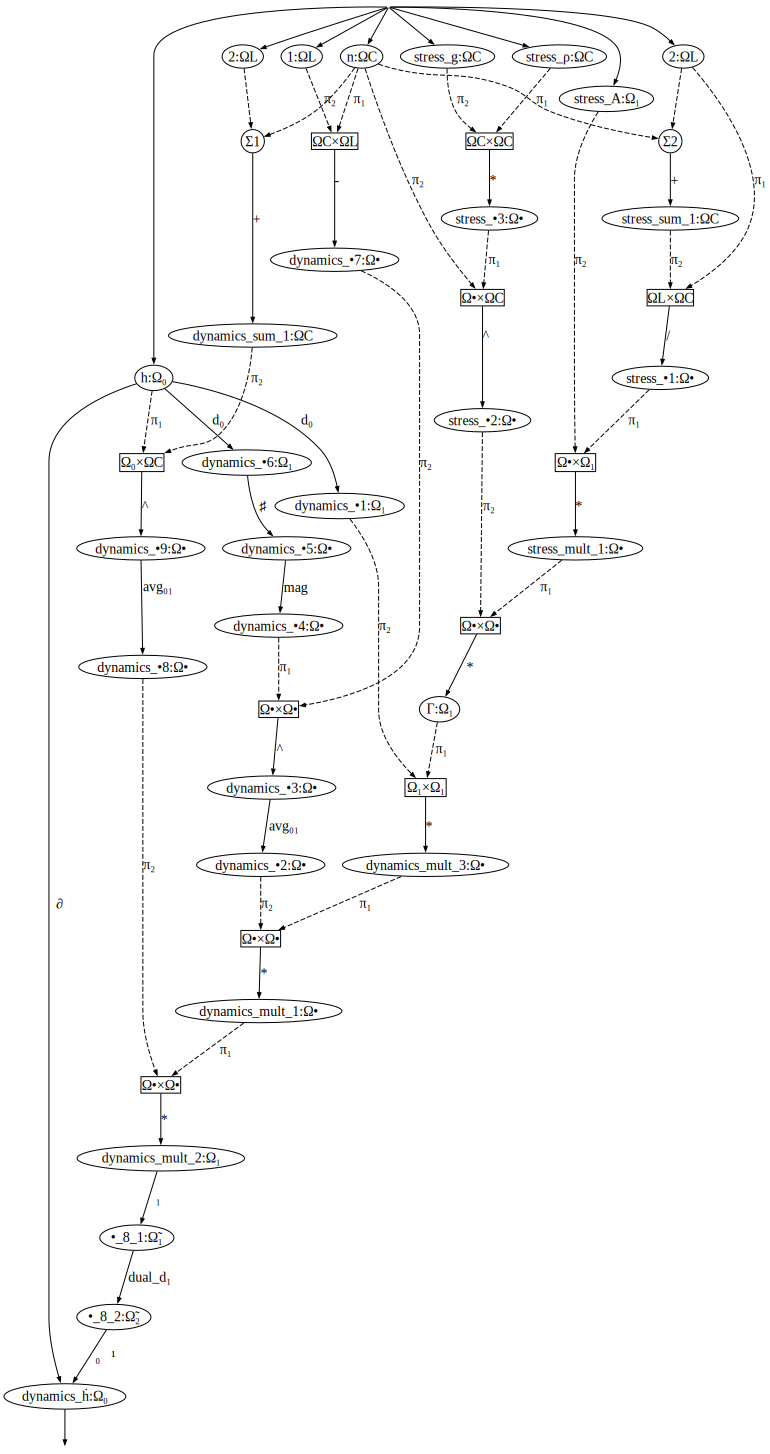

In [3]:
####################
# Define the model #
####################

# Equation 2 from Halfar, P. ON THE DYNAMICS OF THE ICE SHEETS. (1981)
halfar_eq2 = @decapode begin
  h::Form0
  Γ::Form1
  n::Constant

  ḣ == ∂ₜ(h)
  ḣ == ∘(⋆, d, ⋆)(Γ * d(h) * avg₀₁(mag(♯(d(h)))^(n-1)) * avg₀₁(h^(n+2)))
end
to_graphviz(halfar_eq2)

# Equation 1 from Glen, J. W. THE FLOW LAW OF ICE: A discussion of the
# assumptions made in glacier theory, their experimental foundations and
# consequences. (1958)
glens_law = @decapode begin
  (A, Γ)::Form1
  (ρ,g,n)::Constant
  
  Γ == (2/(n+2))*A*(ρ*g)^n
end
to_graphviz(glens_law)

#####################
# Compose the model #
#####################

ice_dynamics_composition_diagram = @relation () begin
  dynamics(h,Γ,n)
  stress(Γ,n)
end
to_graphviz(ice_dynamics_composition_diagram, box_labels=:name, junction_labels=:variable, prog="circo")

ice_dynamics_cospan = oapply(ice_dynamics_composition_diagram,
  [Open(halfar_eq2, [:h,:Γ,:n]),
  Open(glens_law, [:Γ,:n])])

ice_dynamics = apex(ice_dynamics_cospan)
to_graphviz(ice_dynamics)

ice_dynamics = expand_operators(ice_dynamics)
to_graphviz(ice_dynamics)

infer_types!(ice_dynamics)
to_graphviz(ice_dynamics)

resolve_overloads!(ice_dynamics)
to_graphviz(ice_dynamics)

###################
# Store the model #
###################

write_json_acset(ice_dynamics, "ice_dynamics.json")
# When reading back in, we specify that all attributes are "Symbol"s.
ice_dynamics2 = read_json_acset(SummationDecapode{Symbol,Symbol,Symbol}, "ice_dynamics.json")
to_graphviz(ice_dynamics2)
# Or, you could choose to interpret the data as "String"s.
ice_dynamics3 = read_json_acset(SummationDecapode{String,String,String}, "ice_dynamics.json")
to_graphviz(ice_dynamics3)

In [6]:
###################
# Define the mesh #
###################

#include("../../grid_meshes.jl")
include("../grid_meshes.jl")
s′ = triangulated_grid(10_000,10_000,800,800,Point3D)
s = EmbeddedDeltaDualComplex2D{Bool, Float64, Point3D}(s′)
subdivide_duals!(s, Barycenter())

In [13]:
########################################################
# Define constants, parameters, and initial conditions #
########################################################

n = 3
ρ = 910
g = 9.8
A = fill(1e-16, ne(s))

# Ice height is a primal 0-form, with values at vertices.
h₀ = map(point(s′)) do (x,y)
  (7072-((x-5000)^2 + (y-5000)^2)^(1/2))/9e3+10
end

# Visualize initial condition for ice sheet height.
mesh(s′, color=h₀, colormap=:jet)

# Store these values to be passed to the solver.
u₀ = construct(PhysicsState, [VectorForm(h₀), VectorForm(A)], Float64[], [:h, :stress_A])
constants_and_parameters = (
  n = n,
  stress_ρ = ρ,
  stress_g = g)

(n = 3, stress_ρ = 910, stress_g = 9.8)

In [9]:
#############################################
# Define how symbols map to Julia functions #
#############################################

function generate(sd, my_symbol; hodge=GeometricHodge())
  op = @match my_symbol begin
    :♯ => x -> begin
      ♯(sd, EForm(x))
  end
    :mag => x -> begin
      norm.(x)
    end
    :avg₀₁ => x -> begin
      I = Vector{Int64}()
      J = Vector{Int64}()
      V = Vector{Float64}()
      for e in 1:ne(s)
          append!(J, [s[e,:∂v0],s[e,:∂v1]])
          append!(I, [e,e])
          append!(V, [0.5, 0.5])
      end
      avg_mat = sparse(I,J,V)
      avg_mat * x
    end
    :^ => (x,y) -> x .^ y
    :* => (x,y) -> x .* y
    :abs => x -> abs.(x)
    :show => x -> begin
      println(x)
      x
    end
    x => error("Unmatched operator $my_symbol")
  end
  return (args...) -> op(args...)
end

generate (generic function with 1 method)

In [10]:
#######################
# Generate simulation #
#######################

sim = eval(gensim(ice_dynamics, dimension=2))
fₘ = sim(s, generate)

(::var"#f#42"{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, var"#33#41"{var"#29#37"}, var"#33#41"{var"#28#36"}, var"#33#41"{var"#27#35"}, var"#33#41"{var"#26#34"{EmbeddedDeltaDualComplex2D{Bool, Float64, Point3{Float64}}}}, Diagonal{Float64, Vector{Float64}}, SparseMatrixCSC{Int64, Int64}, SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Int64, Int64}}) (generic function with 1 method)

In [14]:
##################
# Run simulation #
##################

tₑ = 5e13

# Julia will pre-compile the generated simulation the first time it is run.
@info("Precompiling Solver")
prob = ODEProblem(fₘ, u₀, (0, 1e-8), constants_and_parameters)
soln = solve(prob, Tsit5())
soln.retcode != :Unstable || error("Solver was not stable")

# This next run should be fast.
@info("Solving")
prob = ODEProblem(fₘ, u₀, (0, tₑ), constants_and_parameters)
soln = solve(prob, Tsit5())
@show soln.retcode
@info("Done")

@save "ice_dynamics.jld2" soln

#############
# Visualize #
#############

# Visualize the final conditions.
mesh(s′, color=findnode(soln(tₑ), :h), colormap=:jet)

# Create a gif
begin
  frames = 100
  fig, ax, ob = GLMakie.mesh(s′, color=findnode(soln(0), :h), colormap=:jet, colorrange=extrema(findnode(soln(tₑ), :h)))
  Colorbar(fig[1,2], ob)
  record(fig, "ice_dynamics.gif", range(0.0, tₑ; length=frames); framerate = 30) do t
    ob.color = findnode(soln(t), :h)
  end
end

[ Info: Precompiling Solver
[ Info: Solving


soln.retcode = SciMLBase.ReturnCode.Success


[ Info: Done


"ice_dynamics.gif"

In [75]:
soln.u[100]

LoadError: BoundsError: attempt to access 23-element Vector{PhysicsState{VectorForm{Float64}, Float64}} at index [100]

In [64]:
print(soln.u[3])

PhysicsState{VectorForm{Float64}, Float64}(VectorForm{Float64}[VectorForm{Float64}([10.000103576459393, 10.058026223678361, 10.110077423040947, 10.154802433323361, 10.190547509522048, 10.215621193840757, 10.228580991008322, 10.228580991008322, 10.215621193840757, 10.190547509522048, 10.154802433323361, 10.110077423040947, 10.058026223678361, 10.09240727353977, 10.153001225166692, 10.207279769188295, 10.253308062798464, 10.288788522542987, 10.31134873852318, 10.319111111111111, 10.31134873852318, 10.288788522542987, 10.253308062798464, 10.207279769188295, 10.153001225166692, 10.09240727353977, 10.113945935207514, 10.182705312340834, 10.246662721907922, 10.303902317328248, 10.35175802440028, 10.386838428652112, 10.405590543299446, 10.405590543299446, 10.386838428652112, 10.35175802440028, 10.303902317328248, 10.246662721907924, 10.182705312340836, 10.197184821233998, 10.269943329645386, 10.338185375822968, 10.399509723551402, 10.450103334061085, 10.48451057804684, 10.496888888888888, 10.

In [67]:
print(soln.u[23])

PhysicsState{VectorForm{Float64}, Float64}(VectorForm{Float64}[VectorForm{Float64}([10.200690880488516, 10.235654493043933, 10.262147999155133, 10.289877914276484, 10.314709118441913, 10.334132107211435, 10.345118677575156, 10.345581221946585, 10.335796989745287, 10.31814966830047, 10.295693859558956, 10.272229867108573, 10.250605620723112, 10.252350359272054, 10.270016693138611, 10.293795445388076, 10.318708773165365, 10.341266127393293, 10.35834221297851, 10.365698507039829, 10.360076056000217, 10.345020368076225, 10.324936852887895, 10.303068362358923, 10.283457068252813, 10.267458035363772, 10.27144188710081, 10.285976008011268, 10.306121556635881, 10.330197239563313, 10.35421094330779, 10.375071061838392, 10.3889270435536, 10.39015062419354, 10.378723680591671, 10.360507086653334, 10.339700378713873, 10.320270817114023, 10.306646137263272, 10.309256834949219, 10.32400020114452, 10.345669958090221, 10.36984862151366, 10.392982971682747, 10.411624200498764, 10.420475925454486, 10.41

In [80]:
findnode(soln(5e12), :h)

VectorForm{Float64}([10.051279050350537, 10.114719446753252, 10.164376745800944, 10.21018082161943, 10.247407536736306, 10.273613154069839, 10.287135427574988, 10.287142302461556, 10.273645357454589, 10.24755191192975  …  10.247657484417113, 10.28741568810032, 10.315630712996589, 10.330256252950038, 10.330264064415896, 10.315666750209083, 10.287578375976038, 10.248247108501545, 10.2025090637481, 10.156142520440431])

In [83]:
# Assuming vector_form is your VectorForm object
vector_form = findnode(soln(5e12), :h)

# Convert each VectorForm element into a regular Julia Vector
list_of_vectors = [collect(vector) for vector in vector_form]

# Display the result
# println(list_of_vectors)
flat_list = reduce(vcat, list_of_vectors)
println(flat_list)


[10.051279050350537, 10.114719446753252, 10.164376745800944, 10.21018082161943, 10.247407536736306, 10.273613154069839, 10.287135427574988, 10.287142302461556, 10.273645357454589, 10.24755191192975, 10.210707298481381, 10.167556583184988, 10.12307811110879, 10.14730123530691, 10.184421554678032, 10.229890789446529, 10.273563669532255, 10.308939737925469, 10.33196080305874, 10.339962894490865, 10.331999450548615, 10.309126621155322, 10.274313682661571, 10.23211199504304, 10.190512955216144, 10.154728939391106, 10.17554863640002, 10.211857288282449, 10.256302810351615, 10.304526099203255, 10.348274801024132, 10.381794156241059, 10.400141497977556, 10.400178286542065, 10.382016005499935, 10.349146613475293, 10.307202108012547, 10.26378299168807, 10.229593198263323, 10.245712231056963, 10.284447056054944, 10.33402303429789, 10.384457239672791, 10.428437193691922, 10.459193811374606, 10.470455313560397, 10.459385716962009, 10.4292152641369, 10.386720151204827, 10.339193781436204, 10.2955004